##Confirmation that datasets exists in the location

In [0]:
# This function was introduced to ensure all related files are present in this path dbfs:/FileStore/tables/ by listing the files.
dbutils.fs.ls("dbfs:/FileStore/tables/clinicaltrial_2021.csv")

Out[1]: [FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2021.csv', name='clinicaltrial_2021.csv', size=50359696)]

In [0]:
dbutils.fs.ls("dbfs:/FileStore/tables/mesh.csv")

Out[2]: [FileInfo(path='dbfs:/FileStore/tables/mesh.csv', name='mesh.csv', size=5295548)]

In [0]:
dbutils.fs.ls("dbfs:/FileStore/tables/pharma.csv")

Out[3]: [FileInfo(path='dbfs:/FileStore/tables/pharma.csv', name='pharma.csv', size=678999)]

##load data and read the textfile to rdd and remove title column

In [0]:
RDD_2021 = sc.textFile("/FileStore/tables/clinicaltrial_2021.csv")
header_2021 = RDD_2021.first()
header = sc.parallelize([header_2021])
headerdata = RDD_2021.subtract(header)

In [0]:
RDD_mesh = sc.textFile("dbfs:/FileStore/tables/mesh.csv")
header_mesh = RDD_mesh.first()
header_meshfile = sc.parallelize([header_mesh])
FinalMesh = RDD_mesh.subtract(header_meshfile)

In [0]:
RDD_pharma = sc.textFile("dbfs:/FileStore/tables/pharma.csv")
header_pharma = RDD_pharma.first()
header_pharmafile = sc.parallelize([header_pharma])
Finalpharma = RDD_mesh.subtract(header_pharmafile)

##QUESTION 1

In [0]:
RDD_2021.subtract(header).count()

Out[7]: 387261

##QUESTION 2

In [0]:
rdd_2021_map = headerdata.map(lambda x : x.split('|')).map(lambda x:x[5]).map(lambda x: (x,1))
rdd2021_reduce = rdd_2021_map.reduceByKey(lambda x,y: x+y).map(lambda x: (x[1],x[0])).sortByKey(ascending = False).map(lambda x: (x[1],x[0]))
rdd2021_reduce.collect()

Out[8]: [('Interventional', 301472),
 ('Observational', 77540),
 ('Observational [Patient Registry]', 8180),
 ('Expanded Access', 69)]

##QUESTION 3

In [0]:
rdd_2021_map_condition = headerdata.map(lambda x : x.split('|')).flatMap(lambda x: x[7].split(',')).map(lambda x: [x, 1])
rdd2021_reduce_condition = rdd_2021_map_condition.reduceByKey(lambda x,y: x+y).map(lambda x: (x[1],x[0]))
rdd2021_sort_condition = rdd2021_reduce_condition.sortByKey(ascending = False).map(lambda x: (x[1],x[0])).filter(lambda x: (x[0] != ''))
rdd2021_sort_condition.take(5)

Out[9]: [('Carcinoma', 13389),
 ('Diabetes Mellitus', 11080),
 ('Neoplasms', 9371),
 ('Breast Neoplasms', 8640),
 ('Syndrome', 8032)]

##QUESTION 4

In [0]:
Map_2021_condition_flat= headerdata.map(lambda x : x.split('|')).flatMap(lambda x: x[7].split(',')).filter(lambda x: x!= '').map(lambda x: [x, 1])
mesh_split = FinalMesh.map(lambda x:(x.split(",")[0],x.split(",")[1].split(".")[0]))
joinedmesh_2021 = Map_2021_condition_flat.join(mesh_split).map(lambda y: (y[1][1],1)).reduceByKey(lambda x,y: x+y)
Sortmesh_2021 = joinedmesh_2021.map(lambda x: (x[1],x[0])).sortByKey(ascending = False).map(lambda x: (x[1],x[0]))
Sortmesh_2021.take(5)


Out[10]: [('C04', 143994),
 ('C23', 136079),
 ('C01', 106674),
 ('C14', 94523),
 ('C10', 92310)]

##QUESTION 5

In [0]:
Map_2021_sponspor_split = RDD_2021.map(lambda x : x.split('|')).map(lambda x : (x[1]))
pharma_split = RDD_pharma.map(lambda x:(x.split(','))).map(lambda x:(x[1]).replace('"', ''))
pharmajoin = Map_2021_sponspor_split.subtract(pharma_split).map(lambda x: (x,1))
pharmajoinreduce = pharmajoin.reduceByKey(lambda x,y: x+y).map(lambda x: (x[1],x[0]))
pharmajoinsort = pharmajoinreduce.sortByKey(ascending = False).map(lambda x: (x[1],x[0]))
pharmajoinsort.take(10)


Out[11]: [('National Cancer Institute (NCI)', 3218),
 ('M.D. Anderson Cancer Center', 2414),
 ('Assistance Publique - Hôpitaux de Paris', 2369),
 ('Mayo Clinic', 2300),
 ('Merck Sharp & Dohme Corp.', 2243),
 ('Assiut University', 2154),
 ('Novartis Pharmaceuticals', 2088),
 ('Massachusetts General Hospital', 1971),
 ('Cairo University', 1928),
 ('Hoffmann-La Roche', 1828)]

##QUESTION 6

In [0]:
import calendar
Monthsort = {i:e for e,i in enumerate(calendar.month_abbr[1:],1)}
completion_split_2021 = headerdata.map(lambda x : x.split('|')).filter(lambda x: (x[2] == 'Completed')).map(lambda x: x[4].split(' ')).filter(lambda x: x[0] != '').filter(lambda x: (x[1] == '2021')).map(lambda x: (x[0],1)).reduceByKey(lambda x,y: x+y)
Finalmonthsort_2021 = completion_split_2021.sortBy(keyfunc=lambda x: Monthsort.get(x[0]))
Finalmonthsort_2021.collect()

Out[12]: [('Jan', 1131),
 ('Feb', 934),
 ('Mar', 1227),
 ('Apr', 967),
 ('May', 984),
 ('Jun', 1094),
 ('Jul', 819),
 ('Aug', 700),
 ('Sep', 528),
 ('Oct', 187)]

##VISUALIZATION OF COMPLETED STUDIES

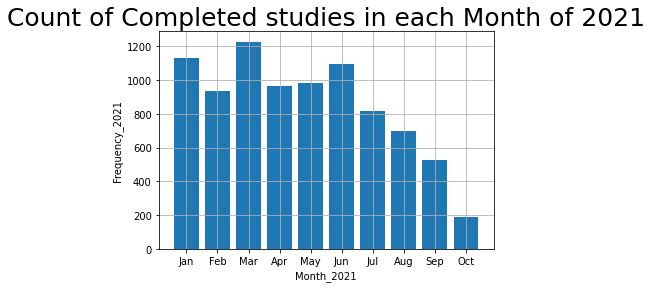

In [0]:
import matplotlib.pyplot as plt
completed_studies_Month=Finalmonthsort_2021.map(lambda x : (x[0])).collect()
completed_studies_Frequency = Finalmonthsort_2021.map(lambda x : (x[1])).collect()
plt.bar(completed_studies_Month, completed_studies_Frequency, width = 0.8)
plt.title("Count of Completed studies in each Month of 2021", fontsize=25)
plt.xlabel("Month_2021")
plt.ylabel("Frequency_2021")
plt.grid()
plt.show()


##FURTHER ANALYSIS OF THE UNCOMPLETED STUDIES

In [0]:
import calendar
Monthsort_Incompletestudy = {i:e for e,i in enumerate(calendar.month_abbr[1:],1)}
Incomplete_studies_split_2021 = headerdata.map(lambda x : x.split('|')).filter(lambda x: (x[2] != 'Completed')).map(lambda x: x[4].split(' ')).filter(lambda x: x[0] != '').filter(lambda x: (x[1] == '2021')).map(lambda x: (x[0],1)).reduceByKey(lambda x,y: x+y)
Finalincomplete_studiessort_2021 = Incomplete_studies_split_2021.sortBy(keyfunc=lambda x: Monthsort_Incompletestudy.get(x[0]))
Finalincomplete_studiessort_2021.collect()

Out[13]: [('Jan', 980),
 ('Feb', 801),
 ('Mar', 1220),
 ('Apr', 1062),
 ('May', 1128),
 ('Jun', 2008),
 ('Jul', 1589),
 ('Aug', 1603),
 ('Sep', 2373),
 ('Oct', 2327),
 ('Nov', 1997),
 ('Dec', 9968)]

##VISUALIZATION OF THE UNCOMPLETED STUDIES

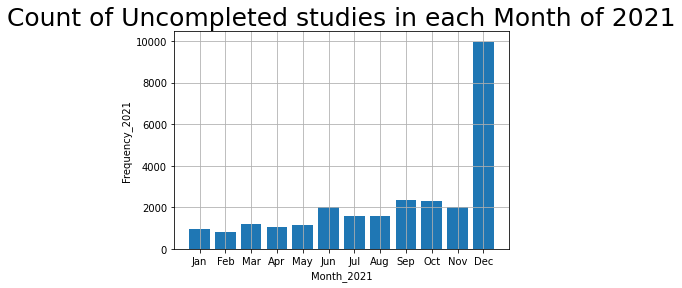

In [0]:
import matplotlib.pyplot as plt
uncompleted_studies_Month=Finalincomplete_studiessort_2021.map(lambda x : (x[0])).collect()
uncompleted_studies_Frequency = Finalincomplete_studiessort_2021.map(lambda x : (x[1])).collect()
plt.bar(uncompleted_studies_Month,uncompleted_studies_Frequency, width = 0.8)
plt.title("Count of Uncompleted studies in each Month of 2021", fontsize=25)
plt.xlabel("Month_2021")
plt.ylabel("Frequency_2021")
plt.grid()
plt.show()